In [1]:
import pandas as pd
import gmaps as gp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mp
import matplotlib.patches as mpatches
from shapely.geometry import shape, MultiPolygon, Point, LineString
import geojson
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))


sns.set_style("whitegrid")
TAM_IMG=(12,8) #Tamaño de las imagenes
dest_img = "./imagenes/"

In [2]:
def guardar_imagen(nombre):
    plt.savefig(dest_img + nombre.strip().replace(' ','-') + '.png')

In [3]:
def plotear_distancias(df,x,y,titulo,color_reg='red',color_scatter='blue',label_x=None,label_y=None):
    fig, ax = plt.subplots(figsize=TAM_IMG)
    fit = np.polyfit(df[x],df[y], deg=1)
    ax.plot(df[x], fit[0] * df[x] + fit[1], color=color_reg)
    ax.scatter(df[x], df[y],color=color_scatter)
    plt.title(titulo,size=20)
    if(label_x and label_y):
        plt.xlabel(label_x)
        plt.ylabel(label_y)
    guardar_imagen(titulo)
    plt.show()

In [4]:
#Distancia minima entre un punto y una lista de puntos
from haversine import haversine
def distancia_minima(partida, points):
    dist_min = 9999999
    distancias=[]
    for destino in points:
        dist= round(haversine(partida,destino),1)
        if (dist<dist_min):
            dist_min = dist
    return dist

In [5]:
properati = pd.read_csv('datos/properati_2.csv')

In [6]:
properati.dtypes

Unnamed: 0                      int64
id                             object
created_on                     object
operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
expenses                      float64
properati_url                  object
description                    object
title       

In [7]:
properati.loc[:,('created_on')] = pd.to_datetime(properati['created_on'])

In [8]:
#Saco algunas columnas que no parecen servir
properati_filtrado = properati.drop( ['country_name','geonames_id','place_with_parent_names','operation','image_thumbnail'], 1)
# los geonames hacen referencia a place_name y no a la propiedad
properati_filtrado.dropna(how='all',inplace=True)
properati_filtrado = properati_filtrado.loc[properati_filtrado.price_per_m2 < 100000]
properati_filtrado['lat-lon'] = zip(properati_filtrado['lat-lon'])

## Cantidad de propiedades segun zona

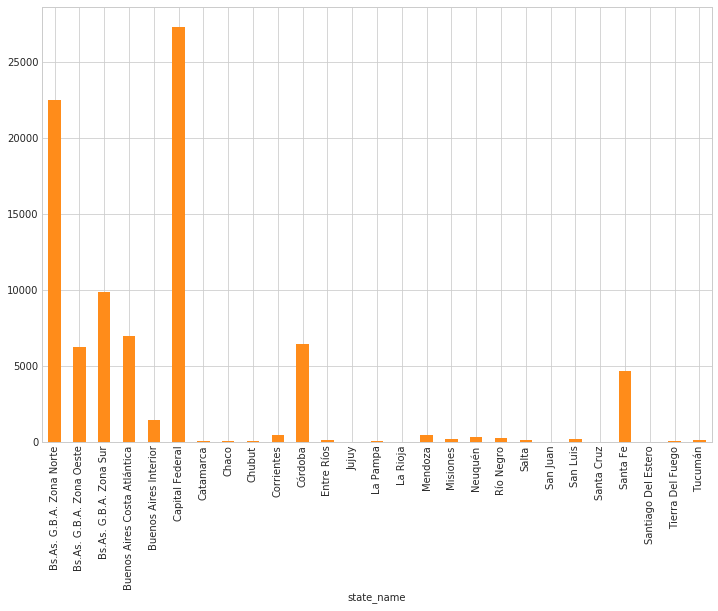

In [9]:
properati_filtrado.groupby('state_name').count()['created_on'].plot(kind='bar',figsize=TAM_IMG,color='#ff8c1a')
titulo = 'Cantidad de propiedades segun zona'
guardar_imagen(titulo)
plt.show()

## Precio por m2 promedio por zona

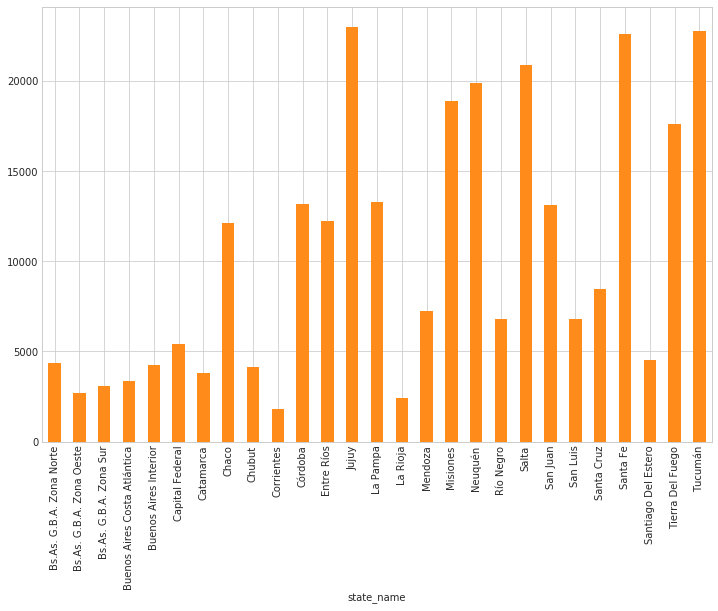

In [10]:
properati_filtrado.groupby('state_name').mean()['price_per_m2'].plot(kind='bar',figsize=TAM_IMG,color='#ff8c1a')
titulo = 'Precio por m2 promedio por zona'
guardar_imagen(titulo)
plt.show()

## Promedio de superficie de propiedades por zona

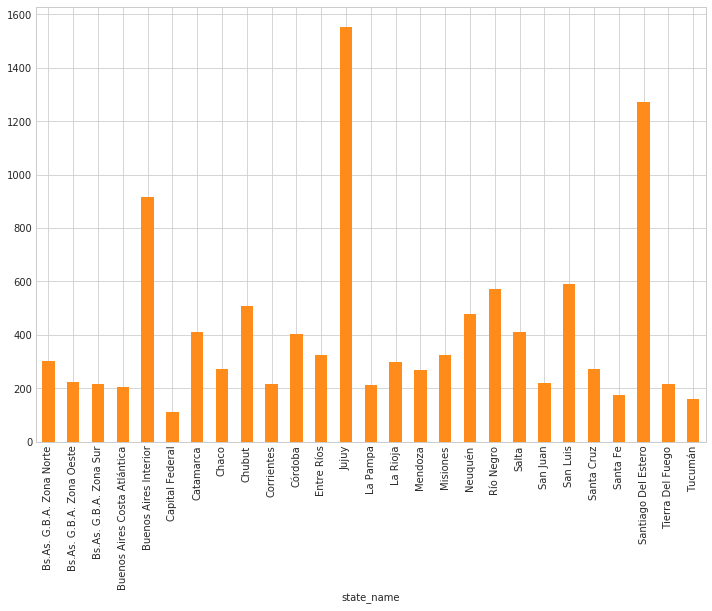

In [11]:
properati_filtrado.groupby('state_name').mean()['surface_total_in_m2'].plot(kind='bar',figsize=TAM_IMG,color='#ff8c1a')
titulo = ' Promedio de superficie de propiedades por zona'
guardar_imagen(titulo)
plt.show()


## Pisos por zona

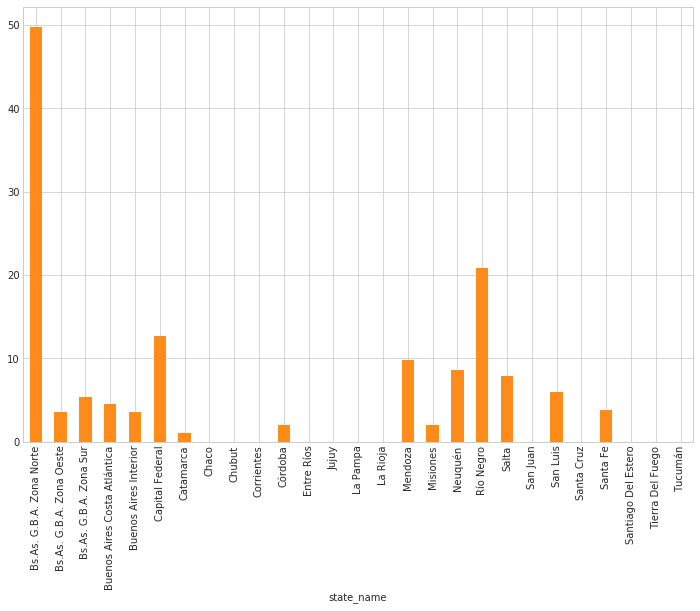

In [12]:
properati_filtrado.groupby('state_name').mean()['floor'].plot(kind='bar',figsize=TAM_IMG,color='#ff8c1a')
titulo = 'Pisos por zona'
guardar_imagen(titulo)
plt.show()

## Cantidad de tipos de propiedades por zona

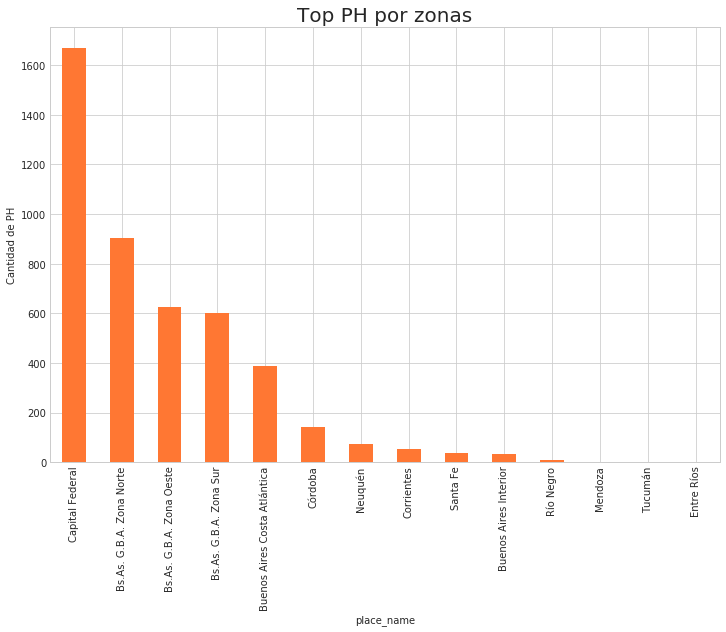

In [13]:
ranking_tipos = properati_filtrado.loc[properati_filtrado['property_type']=='PH'].groupby('state_name').count()['created_on'].sort_values(ascending=False).head(20)
ranking_tipos.plot(kind='bar',figsize=TAM_IMG,color='#ff7733')
titulo = 'Top PH por zonas'
plt.title(titulo,size=20)
plt.xlabel('place_name')
plt.ylabel('Cantidad de PH')
guardar_imagen(titulo)
plt.show()

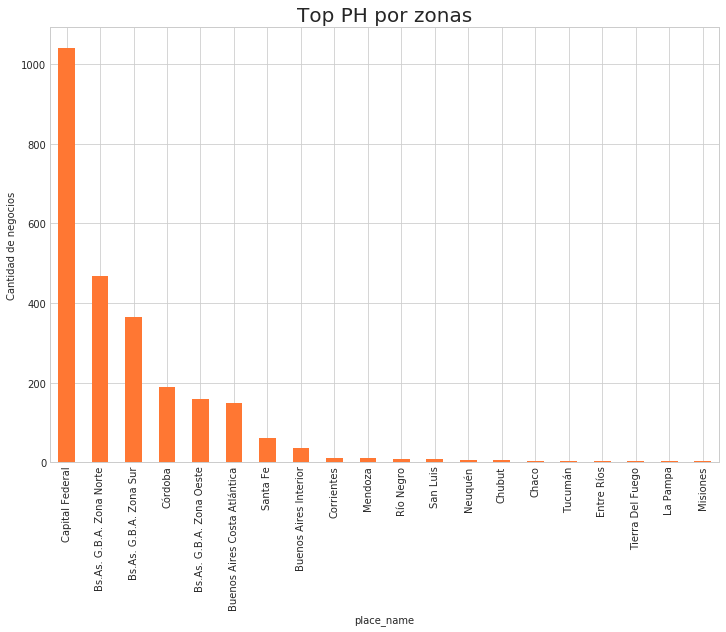

In [14]:
ranking_tipos = properati_filtrado.loc[properati_filtrado['property_type']=='store'].groupby('state_name').count()['created_on'].sort_values(ascending=False).head(20)
ranking_tipos.plot(kind='bar',figsize=TAM_IMG,color='#ff7733')
tiutlo = 'Top negocios por zonas'
plt.title(titulo,size=20)
plt.xlabel('place_name')
plt.ylabel('Cantidad de negocios')
guardar_imagen(titulo)
plt.show()

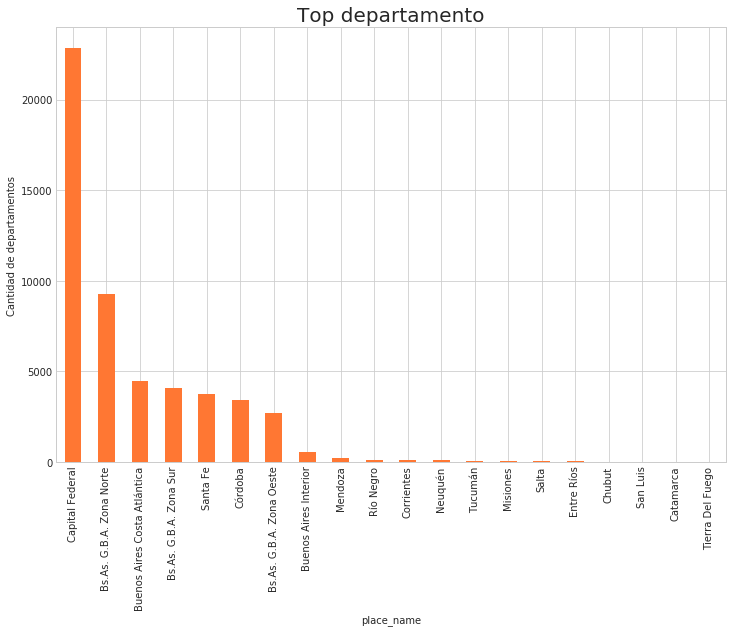

In [15]:
ranking_tipos = properati_filtrado.loc[properati_filtrado['property_type']=='apartment'].groupby('state_name').count()['created_on'].sort_values(ascending=False).head(20)
ranking_tipos.plot(kind='bar',figsize=TAM_IMG,color='#ff7733')
titulo = 'Top departamento por zonas'
plt.title('Top departamento',size=20)
plt.xlabel('place_name')
plt.ylabel('Cantidad de departamentos')
guardar_imagen(titulo)
plt.show()

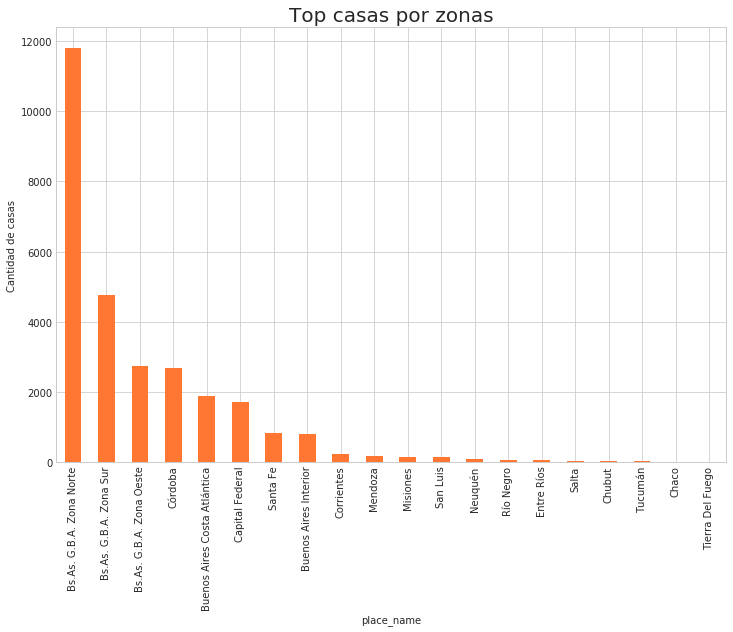

In [16]:
ranking_tipos = properati_filtrado.loc[properati_filtrado['property_type']=='house'].groupby('state_name').count()['created_on'].sort_values(ascending=False).head(20)
ranking_tipos.plot(kind='bar',figsize=TAM_IMG,color='#ff7733')
titulo='Top casas por zonas'
plt.title(titulo,size=20)
plt.xlabel('place_name')
plt.ylabel('Cantidad de casas')
guardar_imagen(titulo)
plt.show()

In [17]:
zona_norte = properati_filtrado.loc[properati_filtrado.state_name.str.contains('Norte')]
zona_sur = properati_filtrado.loc[properati_filtrado.state_name.str.contains('Sur')]
zona_oeste = properati_filtrado.loc[properati_filtrado.state_name.str.contains('Oeste')]
caba = properati_filtrado.loc[properati_filtrado.state_name == 'Capital Federal']

## Ranking precio por m2 por barrios

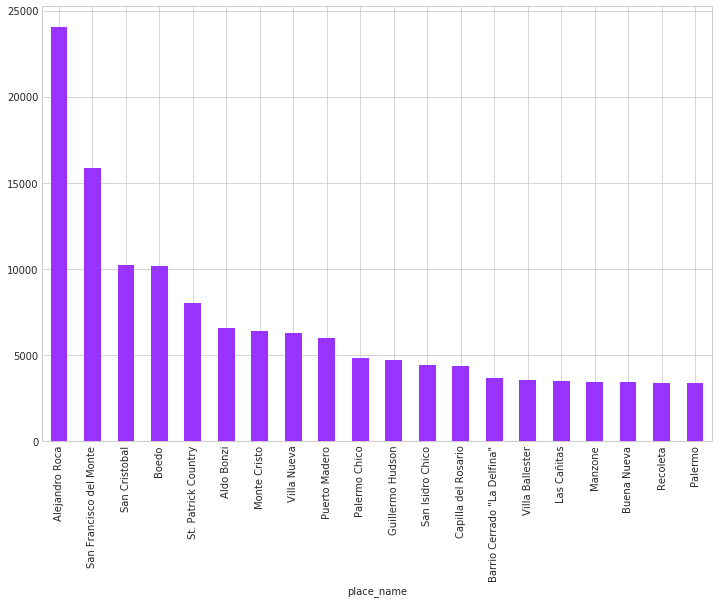

In [18]:
titulo = 'Ranking precio por m2 por barrios'
properati_filtrado.groupby('place_name').mean()['price_usd_per_m2'].sort_values(ascending=False).head(20).plot(kind='bar',figsize=TAM_IMG,color='#9933ff')
guardar_imagen(titulo)
plt.show()

## Ranking precio por m2 de tipo de propiedades por barrios

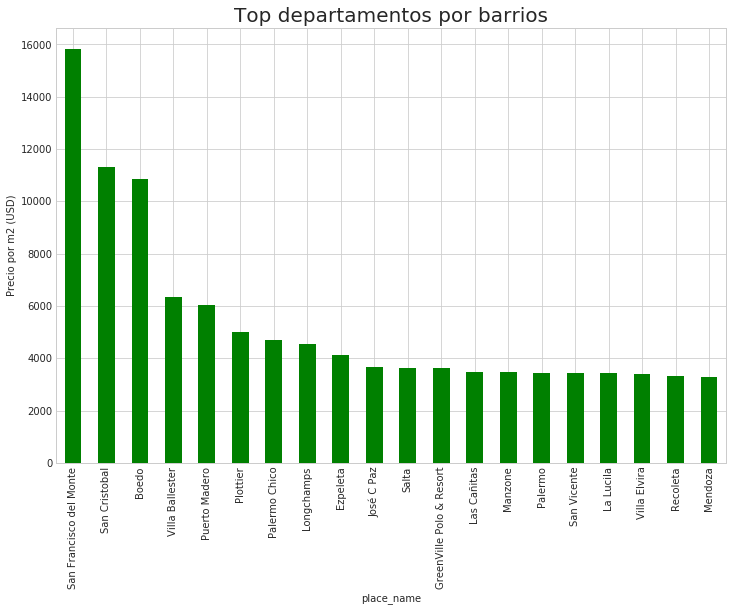

In [19]:
ranking_precios_usd = properati_filtrado.loc[properati_filtrado['property_type']=='apartment'].groupby('place_name').mean()['price_usd_per_m2'].sort_values(ascending=False).head(20)
ranking_precios_usd.plot(kind='bar',figsize=TAM_IMG,color='g')
titulo = 'Top departamentos por barrios'
plt.title(titulo,size=20)
plt.xlabel('place_name')
plt.ylabel('Precio por m2 (USD)')
guardar_imagen(titulo)
plt.show()

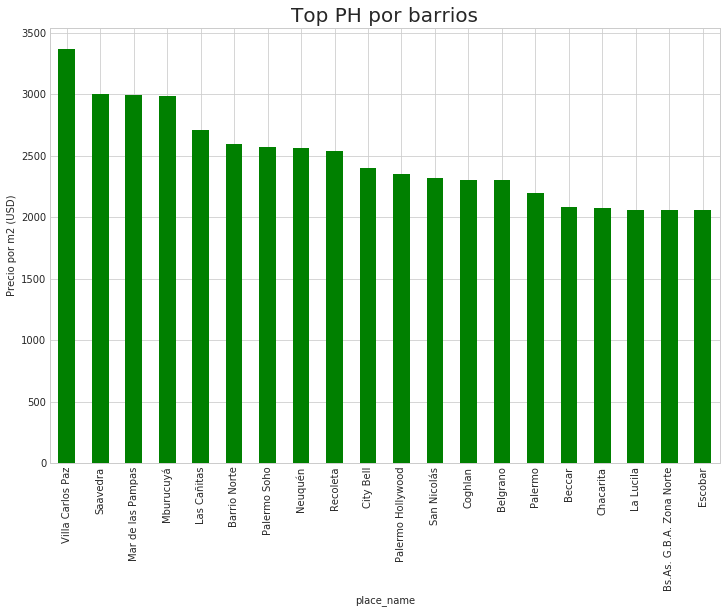

In [20]:
ranking_precios_usd = properati_filtrado.loc[properati_filtrado['property_type']=='PH'].groupby('place_name').mean()['price_usd_per_m2'].sort_values(ascending=False).head(20)
ranking_precios_usd.plot(kind='bar',figsize=TAM_IMG,color='g')
titulo = 'Top PH por barrios'
plt.title(titulo,size=20)
plt.xlabel('place_name')
plt.ylabel('Precio por m2 (USD)')
guardar_imagen(titulo)
plt.show()

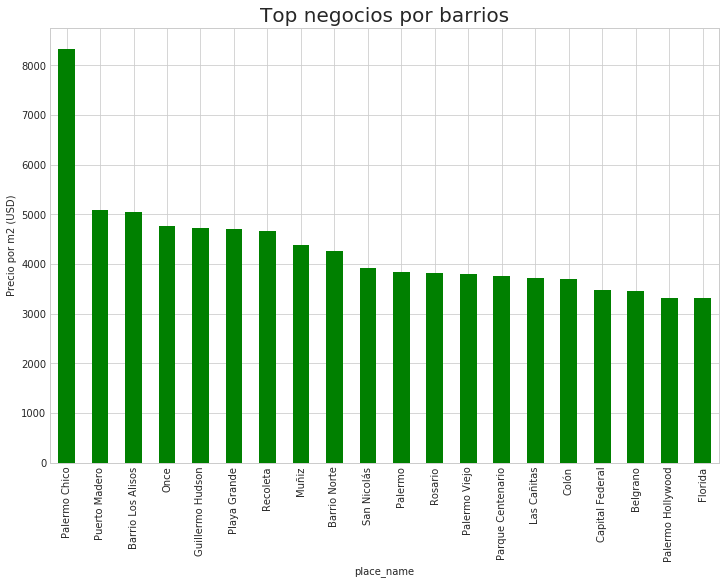

In [21]:
ranking_precios_usd = properati_filtrado.loc[properati_filtrado['property_type']=='store'].groupby('place_name').mean()['price_usd_per_m2'].sort_values(ascending=False).head(20)
ranking_precios_usd.plot(kind='bar',figsize=TAM_IMG,color='g')
titulo = 'Top negocios por barrios'
plt.title(titulo,size=20)
plt.xlabel('place_name')
plt.ylabel('Precio por m2 (USD)')
guardar_imagen(titulo)
plt.show()

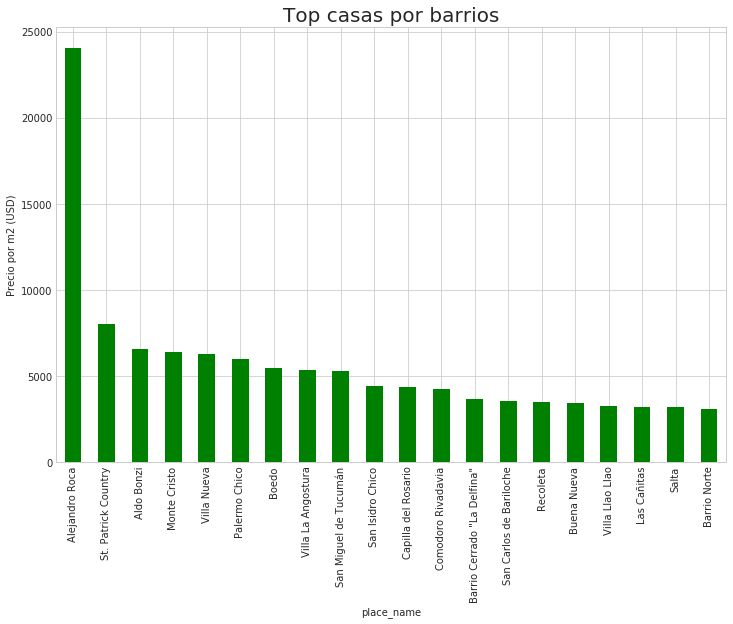

In [22]:
ranking_precios_usd = properati_filtrado.loc[properati_filtrado['property_type']=='house'].groupby('place_name').mean()['price_usd_per_m2'].sort_values(ascending=False).head(20)
ranking_precios_usd.plot(kind='bar',figsize=TAM_IMG,color='g')
titulo = 'Top casas por barrios'
plt.title(titulo,size=20)
plt.xlabel('place_name')
plt.ylabel('Precio por m2 (USD)')
guardar_imagen(titulo)
plt.show()

## Ranking cantidad de propiedades por barrios


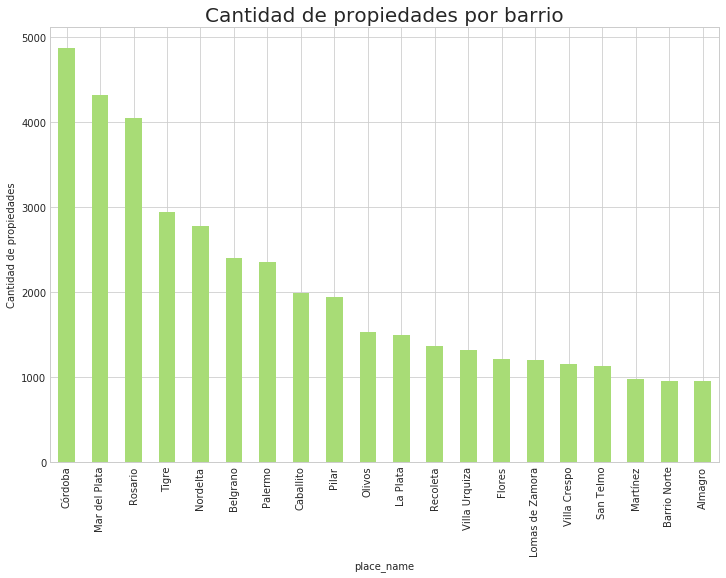

In [23]:
ranking_tipos = properati_filtrado.groupby('place_name').count()['created_on'].sort_values(ascending=False).head(20)
ranking_tipos.plot(kind='bar',figsize=TAM_IMG,color='#a8dc76')
titulo = 'Cantidad de propiedades por barrio'
plt.title(titulo,size=20)
plt.xlabel('place_name')
plt.ylabel('Cantidad de propiedades')
guardar_imagen(titulo)
plt.show()

## Ranking cantidad de tipos de propiedades por barrios

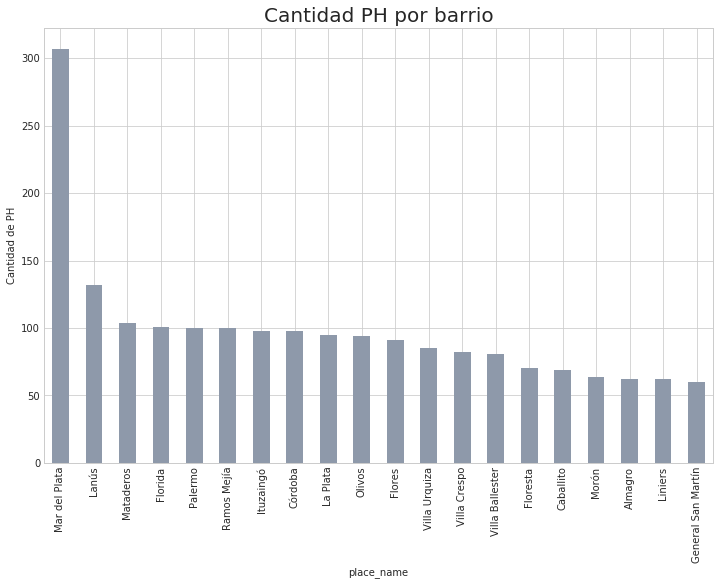

In [24]:
ranking_tipos = properati_filtrado.loc[properati_filtrado['property_type']=='PH'].groupby('place_name').count()['created_on'].sort_values(ascending=False).head(20)
ranking_tipos.plot(kind='bar',figsize=TAM_IMG,color='#8e99aa')
titulo = 'Cantidad PH por barrio'
plt.title(titulo,size=20)
plt.xlabel('place_name')
plt.ylabel('Cantidad de PH')
guardar_imagen(titulo)
plt.show()

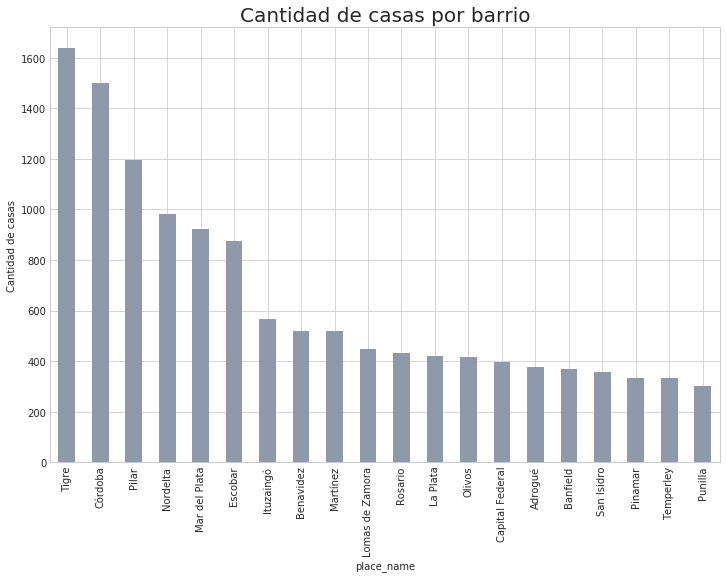

In [25]:
ranking_tipos = properati_filtrado.loc[properati_filtrado['property_type']=='house'].groupby('place_name').count()['created_on'].sort_values(ascending=False).head(20)
ranking_tipos.plot(kind='bar',figsize=TAM_IMG,color='#8e99aa')
titulo = 'Cantidad de casas por barrio'
plt.title(titulo,size=20)
plt.xlabel('place_name')
plt.ylabel('Cantidad de casas')
guardar_imagen(titulo)
plt.show()

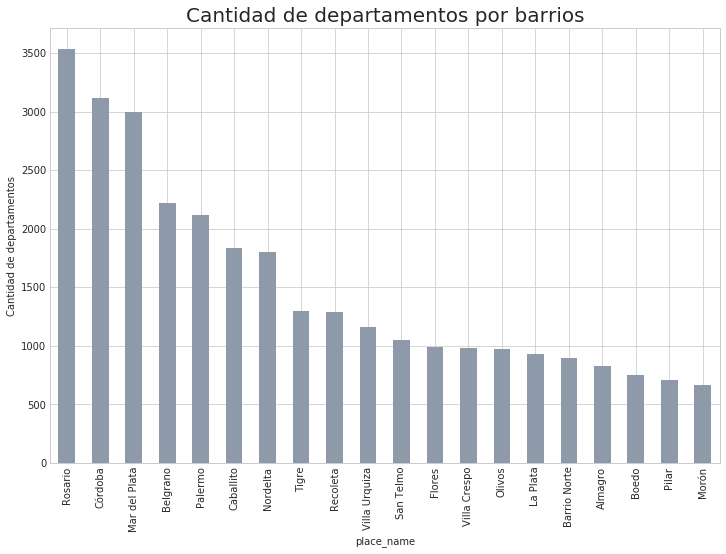

In [26]:
ranking_tipos = properati_filtrado.loc[properati_filtrado['property_type']=='apartment'].groupby('place_name').count()['created_on'].sort_values(ascending=False).head(20)
ranking_tipos.plot(kind='bar',figsize=TAM_IMG,color='#8e99aa')
titulo = 'Cantidad de departamentos por barrios'
plt.title(titulo,size=20)
plt.xlabel('place_name')
plt.ylabel('Cantidad de departamentos')
guardar_imagen(titulo)
plt.show()

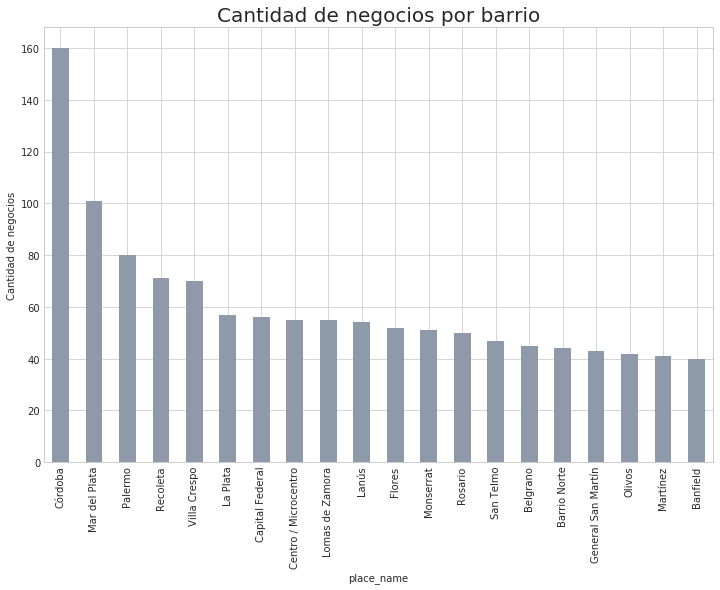

In [27]:
ranking_tipos = properati_filtrado.loc[properati_filtrado['property_type']=='store'].groupby('place_name').count()['created_on'].sort_values(ascending=False).head(20)
ranking_tipos.plot(kind='bar',figsize=TAM_IMG,color='#8e99aa')
titulo='Cantidad de negocios por barrio'
plt.title(titulo,size=20)
plt.xlabel('place_name')
plt.ylabel('Cantidad de negocios')
guardar_imagen(titulo)
plt.show()

In [28]:
propiedades_full=properati


In [29]:
properties_by_type=propiedades_full[['place_name','property_type']]


In [30]:
properties_by_type_and_total=properties_by_type.groupby('place_name').count().reset_index()

In [31]:
properties_by_type_and_total.columns=['place_name','total_properties']
properties_by_type_and_total

,place_name,total_properties
0,Country Maschwitz Club,3
1,los alamos,1
2,9 de Abril,3
3,Abasto,139
4,Abril Club de Campo,19
5,Acacias Blancas,34
6,Acassuso,242
7,Achiras,8
8,Adolfo Alsina,8
9,Adrogué,734


In [32]:
properties_by_type=properties_by_type.groupby('place_name').apply(lambda x: x['property_type'].value_counts()).reset_index()
properties_by_type=pd.pivot_table(properties_by_type,index=['place_name'],columns=['level_1']).reset_index()
properties_by_type

place_name property_type                   \
level_1                                                PH apartment  house   
0                    Country Maschwitz Club           NaN       NaN    3.0   
1                                los alamos           NaN       1.0    NaN   
2                                9 de Abril           NaN       NaN    1.0   
3                                    Abasto          14.0      79.0   37.0   
4                       Abril Club de Campo           NaN       NaN   19.0   
5                           Acacias Blancas           NaN       NaN   34.0   
6                                  Acassuso           8.0      88.0  138.0   
7                                   Achiras           NaN       4.0    3.0   
8                             Adolfo Alsina           NaN       NaN    8.0   
9                                   Adrogué          25.0     172.0  503.0   
10          Aeropuerto Internacional Ezeiza           NaN       NaN    2.0   
11                                Agronomía           7.0      29.0    4.0   
12                              Agua Blanca           NaN       NaN    1.0   
13                              Agua de Oro           NaN       NaN    6.0   
14                             Aguas Verdes           2.0       8.0    5.0   
15                 Albanueva Barrio Cerrado           NaN      15.0   11.0   
16                          Aldea Brasilera           NaN       NaN    1.0   
17                              Aldea Salto           NaN       NaN    1.0   
18                               Aldo Bonzi           NaN       NaN    5.0   
19                           Alejandro Korn           NaN       1.0   14.0   
20                           Alejandro Roca           NaN       NaN    1.0   
21                                     Alem           NaN       2.0    NaN   
22                                    Alfar           NaN       NaN    1.0   
23                               Almafuerte           NaN       NaN    7.0   
24                                  Almagro          68.0    1023.0   38.0   
25                          Almirante Brown           2.0      13.0   26.0   
26                              Alta Gracia           NaN       3.0   15.0   
27                                 Altamira           NaN       NaN   14.0   
28                        Alto Los Cardales           NaN       NaN    3.0   
29                        Altos de Hudson I           NaN       NaN    1.0   
...                                     ...           ...       ...    ...   
1030              Villa Santa Cruz del Lago           NaN       1.0   10.0   
1031                       Villa Santa Rita          13.0      32.0   11.0   
1032                        Villa Sarmiento          20.0      78.0   53.0   
1033                          Villa Soldati           2.0       8.0    3.0   
1034                            Villa Tesei           NaN       2.0   12.0   
1035                          Villa Udaondo           1.0       1.0   23.0   
1036                            Villa Unión           NaN       1.0    NaN   
1037                          Villa Urquiza          92.0    1451.0   65.0   
1038                         Villa Vatteone           1.0       1.0    4.0   
1039                          Villa Ventana           NaN       NaN    1.0   
1040                     Villa de Las Rosas           NaN       NaN    4.0   
1041                          Villa de Mayo           NaN      10.0   25.0   
1042                          Villa de Soto           NaN       NaN    2.0   
1043                        Villa del Dique           NaN       NaN   23.0   
1044                       Villa del Parque          47.0     378.0   50.0   
1045                      Villa del Totoral           NaN       NaN    8.0   
1046     Village Golf & Tennis Country Club           NaN       NaN    7.0   
1047                                Villars           NaN       NaN    1.0   
1048                       Virasoro Village           N

In [33]:
 properties_by_type.columns=['place_name','PH','apartment','house','store']

In [34]:
properties_by_type_and_total=pd.merge(properties_by_type,properties_by_type_and_total,on = 'place_name', how='left')

In [35]:
properties_by_type_and_total_mean=properties_by_type_and_total

In [36]:
properties_by_type_and_total_mean=properties_by_type_and_total_mean.fillna(value=0)

In [37]:
properties_by_type_and_total_mean.loc[:,('apartment_percent')]=properties_by_type_and_total_mean['apartment']/properties_by_type_and_total_mean['total_properties']
properties_by_type_and_total_mean.loc[:,('PH_percent')]=properties_by_type_and_total_mean['PH']/properties_by_type_and_total_mean['total_properties']
properties_by_type_and_total_mean.loc[:,('house_percent')]=properties_by_type_and_total_mean['house']/properties_by_type_and_total_mean['total_properties']
properties_by_type_and_total_mean.loc[:,('store_percent')]=properties_by_type_and_total_mean['store']/properties_by_type_and_total_mean['total_properties']

In [38]:
properties_by_type_and_total_mean

,place_name,PH,apartment,house,store,total_properties,apartment_percent,PH_percent,house_percent,store_percent
0,Country Maschwitz Club,0.0,0.0,3.0,0.0,3,0.000000,0.000000,1.000000,0.000000
1,los alamos,0.0,1.0,0.0,0.0,1,1.000000,0.000000,0.000000,0.000000
2,9 de Abril,0.0,0.0,1.0,2.0,3,0.000000,0.000000,0.333333,0.666667
3,Abasto,14.0,79.0,37.0,9.0,139,0.568345,0.100719,0.266187,0.064748
4,Abril Club de Campo,0.0,0.0,19.0,0.0,19,0.000000,0.000000,1.000000,0.000000
5,Acacias Blancas,0.0,0.0,34.0,0.0,34,0.000000,0.000000,1.000000,0.000000
6,Acassuso,8.0,88.0,138.0,8.0,242,0.363636,0.033058,0.570248,0.033058
7,Achiras,0.0,4.0,3.0,1.0,8,0.500000,0.000000,0.375000,0.125000
8,Adolfo Alsina,0.0,0.0,8.0,0.0,8,0.000000,0.000000,1.000000,0.000000
9,Adrogué,25.0,172.0,503.0,34.0,734,0.234332,0.034060,0.685286,0.046322


In [39]:
properties_by_usd_m2=propiedades_full[['place_name','price_usd_per_m2']].dropna().groupby('place_name').mean().reset_index()

In [40]:
properties_by_m2_and_type_mean=pd.merge(properties_by_usd_m2,properties_by_type_and_total_mean,on='place_name',how='left')

In [41]:
properties_by_m2_and_type_mean_greater_than_20 = properties_by_m2_and_type_mean[properties_by_m2_and_type_mean['total_properties']>20]\
[['apartment_percent','PH_percent','store_percent','house_percent','price_usd_per_m2']].groupby('price_usd_per_m2').mean().reset_index()

In [42]:
def agrupar_scatter(df,x,y,color,label):
    plot=ax.scatter(df[x], df[y],color=color,label=label)

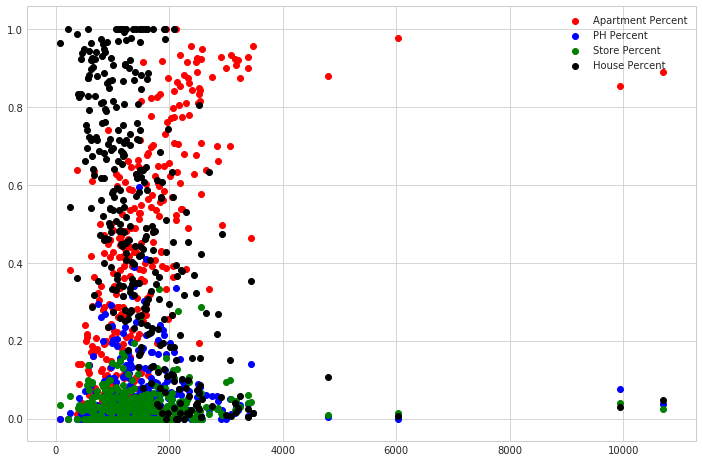

In [43]:
fig, ax = plt.subplots(figsize=TAM_IMG)
agrupar_scatter(properties_by_m2_and_type_mean_greater_than_20,'price_usd_per_m2','apartment_percent','red','Apartment Percent')
agrupar_scatter(properties_by_m2_and_type_mean_greater_than_20,'price_usd_per_m2','PH_percent','blue','PH Percent')
agrupar_scatter(properties_by_m2_and_type_mean_greater_than_20,'price_usd_per_m2','store_percent','green','Store Percent')
agrupar_scatter(properties_by_m2_and_type_mean_greater_than_20,'price_usd_per_m2','house_percent','black','House Percent')
plt.legend(loc='upper right')
plt.show()

In [44]:
def aproximaciones_lineales_agrupadas(df,x,y,color,ax,label):
    fit = np.polyfit(df[x],df[y], deg=1)
    ax.plot(df[x], fit[0] * df[x] + fit[1], color=color,label=label)


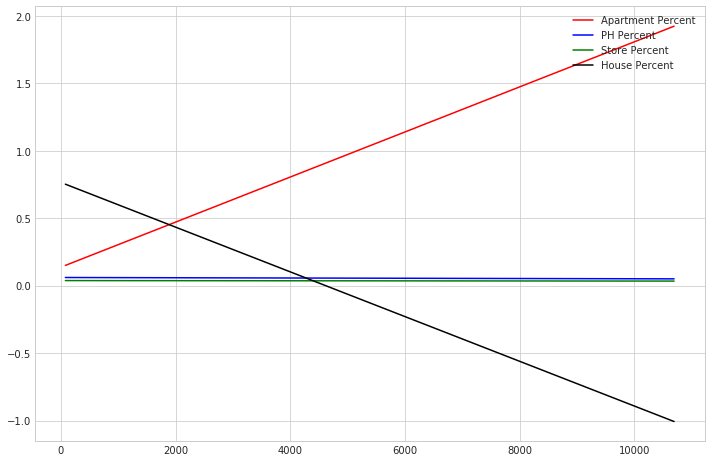

In [45]:
fig, ax = plt.subplots(figsize=TAM_IMG)
aproximaciones_lineales_agrupadas(properties_by_m2_and_type_mean_greater_than_20,'price_usd_per_m2','apartment_percent','red',ax,'Apartment Percent')
aproximaciones_lineales_agrupadas(properties_by_m2_and_type_mean_greater_than_20,'price_usd_per_m2','PH_percent','blue',ax,'PH Percent')
aproximaciones_lineales_agrupadas(properties_by_m2_and_type_mean_greater_than_20,'price_usd_per_m2','store_percent','green',ax,'Store Percent')
aproximaciones_lineales_agrupadas(properties_by_m2_and_type_mean_greater_than_20,'price_usd_per_m2','house_percent','black',ax,'House Percent')
plt.legend(loc='upper right')
plt.show()


## propiedades con patio y a estrenar

In [46]:
news_properties_with_garden=pd.DataFrame({'place_name':propiedades_full['place_name']\
                                          ,'description':propiedades_full['description'],'price_usd_per_m2':propiedades_full['price_usd_per_m2']})


In [47]:
news_properties_with_garden=news_properties_with_garden.dropna(how='any')

In [48]:
news_properties_with_garden.loc[:,'has_garden']=news_properties_with_garden.loc[:,'description'].str.lower().str.contains('patio')
news_properties_with_garden.loc[:,'is_new']=news_properties_with_garden.loc[:,'description'].str.lower().str.contains('estrenar')

In [49]:
#news_properties_with_garden.plot.bar()

## Veamos cuales son las ciudades que vendieron más casas con patio

In [50]:
properties_total=propiedades_full[['place_name','property_type']]
#Calculo el total de las ventas por ciudad
properties_total=properties_total.groupby('place_name').count().reset_index()

In [51]:
properties_total.columns=['place_name','total']

In [52]:
#Calculo la cantidad de casas con jardines vendidas por ciudad
properties_garden_count=news_properties_with_garden[['place_name','has_garden']][news_properties_with_garden['has_garden']]\
.groupby('place_name').count().reset_index()

In [53]:
#Merge entre cantidad de casas con jardines con cantidad total de casas
properties_garden_count=pd.merge(properties_garden_count,properties_total,on='place_name',how='left')

In [54]:
properties_garden_count.loc[:,('has_garden_percent')]=properties_garden_count['has_garden']/properties_garden_count['total']

In [55]:
#Elimino los datos con menores a 50 ventas.
properties_garden_count=properties_garden_count[properties_garden_count['total']>50]

In [56]:
property_by_price_m2_and_place=properati_filtrado.groupby('place_name').mean()['price_usd_per_m2'].reset_index()
properties_garden_count=pd.merge(properties_garden_count,property_by_price_m2_and_place,on='place_name',how='left')
properties_garden_count=properties_garden_count[properties_garden_count['price_usd_per_m2']<4000]

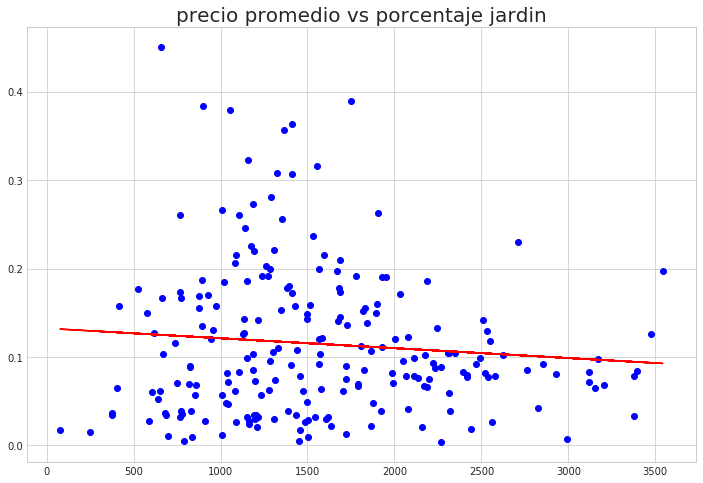

In [57]:
plotear_distancias(properties_garden_count,'price_usd_per_m2','has_garden_percent','precio promedio vs porcentaje jardin')

## Mismo análisis con propiedades a estrenar

In [58]:
#Calculo la cantidad de casas con jardines vendidas por ciudad
news_properties_count=news_properties_with_garden[['place_name','is_new']][news_properties_with_garden['is_new']]\
.groupby('place_name').count().reset_index()
#Merge entre cantidad de casas a estrenar con cantidad total de casas
news_properties_count=pd.merge(news_properties_count,properties_total,on='place_name',how='left')


In [59]:
news_properties_count.loc[:,('is_new_percent')]=news_properties_count['is_new']/news_properties_count['total']

In [60]:
#Elimino los datos con menores a 50 ventas.
news_properties_count=news_properties_count[news_properties_count['total']>50]

In [61]:
property_by_price_m2_and_place=properati_filtrado.groupby('place_name').mean()['price_usd_per_m2'].reset_index()
news_properties_count=pd.merge(news_properties_count,property_by_price_m2_and_place,on='place_name',how='left')
news_properties_count=news_properties_count[news_properties_count['price_usd_per_m2']<4000]

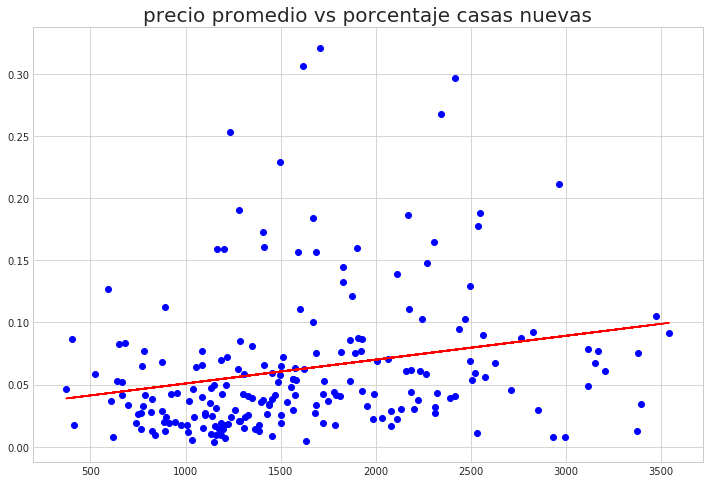

In [62]:
plotear_distancias(news_properties_count,'price_usd_per_m2','is_new_percent','precio promedio vs porcentaje casas nuevas')

## Cual es el tipo de propiedad que se vende mas?

In [63]:
top_tipos=properati_filtrado.groupby('property_type')['price'].count().sort_values()
top_tipos

property_type
store         2533
PH            4537
house        28247
apartment    52104
Name: price, dtype: int64

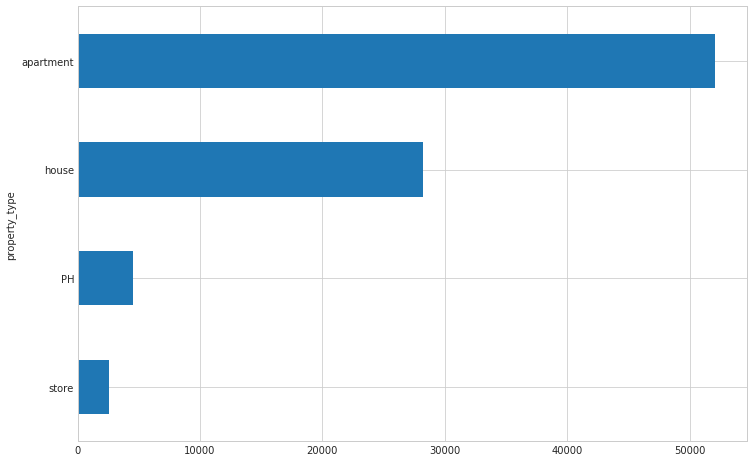

In [64]:
top_tipos.plot(kind='barh',figsize=TAM_IMG)
#plt.set_ylabel('Tipo')
#plt.set_xlabel('Cantidad')
plt.show()

## Promedio de precio por tipo

In [65]:
promedio_por_tipo = properati_filtrado.groupby('property_type')['price_usd_per_m2'].mean()

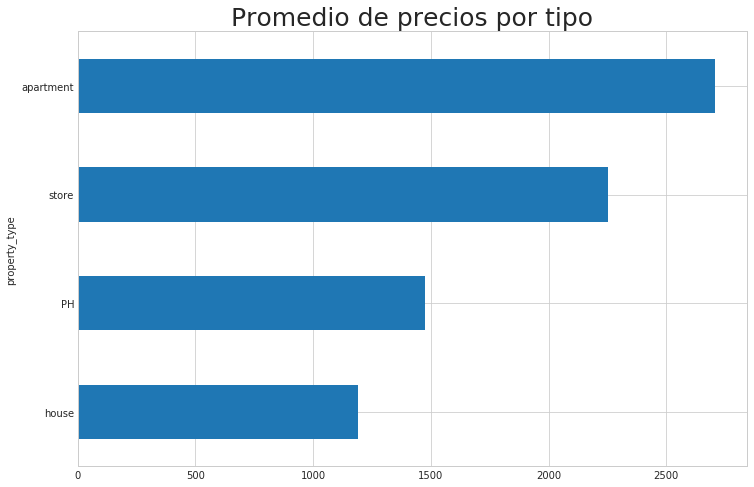

In [66]:
promedio_por_tipo.sort_values().plot(kind='barh',figsize=TAM_IMG)
titulo = 'Promedio de precios por tipo'
plt.title(titulo,size=25)
guardar_imagen(titulo)
plt.show()

## Promedio precio por m2 por mes

In [67]:
properati_filtrado['fecha'] = [(x.year,x.month) for x in properati_filtrado['created_on'] ]
propiedades_por_mes = properati_filtrado.loc[properati_filtrado['fecha']>(2015,1)]
propiedades_por_mes = propiedades_por_mes.groupby(['property_type',properati_filtrado['fecha']])

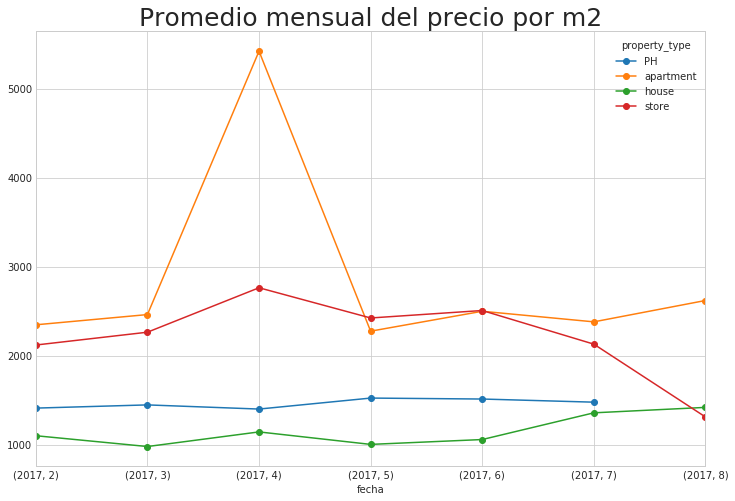

In [68]:
promedio_por_tipo_y_mes= propiedades_por_mes['price_usd_per_m2'].mean().unstack(level=0)
promedio_por_tipo_y_mes.plot(kind='line',marker="o",figsize=TAM_IMG)
titulo = 'Promedio mensual del precio por m2'
plt.title(titulo,size=25)
guardar_imagen(titulo)
plt.show()

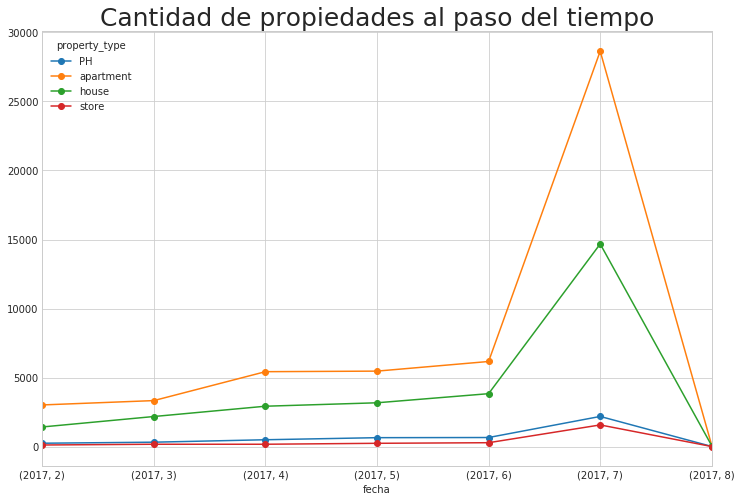

In [69]:
cantidad_por_mes = propiedades_por_mes.count()['created_on'].unstack(level=0)
cantidad_por_mes.plot(kind='line',marker="o",figsize=TAM_IMG)
titulo = 'Cantidad de propiedades al paso del tiempo'
plt.title(titulo,size=25)
guardar_imagen(titulo)
plt.show()

## Cantidad de pisos a traves del tiempo

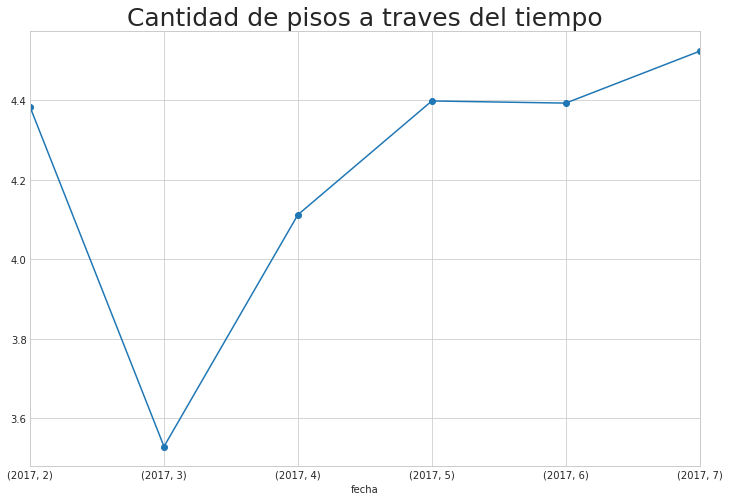

In [70]:
pisos_vs_tiempo = properati_filtrado.loc[properati_filtrado.floor < 55] #https://es.wikipedia.org/wiki/Anexo:Edificios_m%C3%A1s_altos_de_Argentina
pisos_vs_tiempo = pisos_vs_tiempo.loc[pisos_vs_tiempo['fecha']>(2015,1)]
pisos_vs_tiempo.groupby('fecha').mean()['floor'].plot(kind='line',marker="o",figsize=TAM_IMG)
titulo = 'Cantidad de pisos a traves del tiempo'
plt.title(titulo,size=25)
guardar_imagen(titulo)
plt.show()

##  Mayor cantidad de publicaciones respecto de las expensas y el precio total

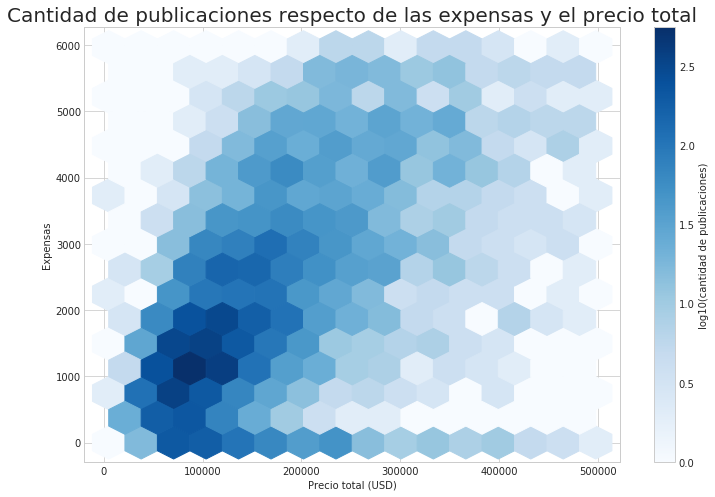

In [71]:
expensas_vs_precio = properati_filtrado.loc[(properati_filtrado['property_type'] == 'apartment') & (properati_filtrado.expenses<6000) & (properati_filtrado.expenses>0) & (properati_filtrado.price_aprox_usd <500000)].loc[:,('price_aprox_usd','expenses')].dropna() #hay unas expensas mal
plt.figure(figsize=TAM_IMG)
plt.hexbin(expensas_vs_precio['price_aprox_usd'],expensas_vs_precio['expenses'], gridsize=15,bins='log',cmap='Blues')
cb = plt.colorbar()
cb.set_label('log10(cantidad de publicaciones)')
titulo = 'Cantidad de publicaciones respecto de las expensas y el precio total'
plt.title(titulo,size=20)
plt.ylabel('Expensas')
plt.xlabel('Precio total (USD)')
guardar_imagen(titulo)
plt.show()

##  Mayor cantidad de publicaciones respecto de las expensas y el precio por m2

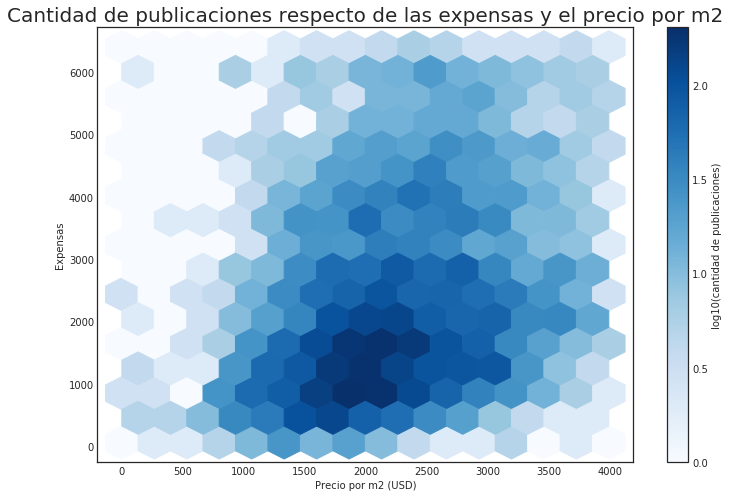

In [72]:
expensas_vs_precio = properati_filtrado.loc[(properati_filtrado['property_type'] == 'apartment') & (properati_filtrado.price_usd_per_m2<4000) & (properati_filtrado.expenses>50) & (properati_filtrado.expenses<6500)].loc[:,('price_usd_per_m2','expenses')].dropna() #hay unas expensas mal
plt.figure(figsize=TAM_IMG)
sns.set_style("white")
plt.hexbin(expensas_vs_precio['price_usd_per_m2'],expensas_vs_precio['expenses'], gridsize=15,bins='log',cmap='Blues')
cb = plt.colorbar()
cb.set_label('log10(cantidad de publicaciones)')
titulo = 'Cantidad de publicaciones respecto de las expensas y el precio por m2'
plt.title(titulo,size=20)
plt.ylabel('Expensas')
plt.xlabel('Precio por m2 (USD)')
guardar_imagen(titulo)
plt.show()

##  Superficie descubierta vs precio 

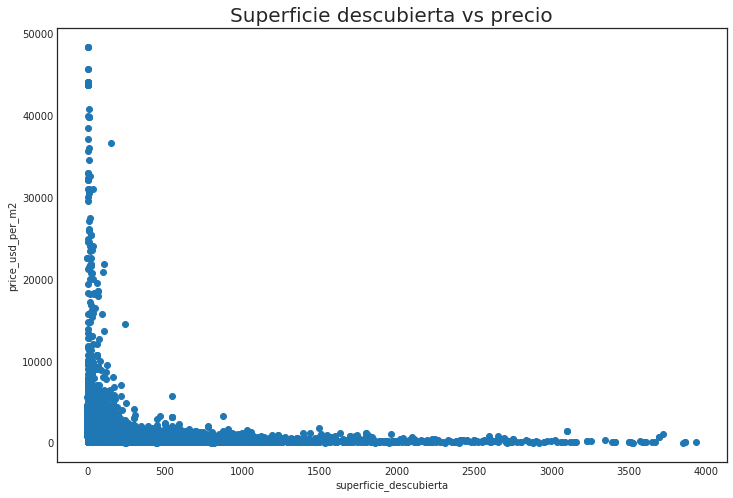

In [73]:
properati_filtrado.loc[:,'superficie_descubierta'] = properati_filtrado['surface_total_in_m2'] - properati_filtrado['surface_covered_in_m2']
properati_filtrado.loc[:,'superficie_descubierta'] = properati_filtrado.loc[properati_filtrado.superficie_descubierta>0 &((properati_filtrado.property_type == "PH")|(properati_filtrado.property_type == "apartment"))]
precio_vs_descubierto= properati_filtrado.loc[:,('price_usd_per_m2','superficie_descubierta')].dropna()
precio_vs_descubierto.groupby('superficie_descubierta').mean()
precio_vs_descubierto = precio_vs_descubierto.loc[precio_vs_descubierto.superficie_descubierta<4000]

plt.figure(figsize=TAM_IMG)
plt.scatter(precio_vs_descubierto['superficie_descubierta'],precio_vs_descubierto['price_usd_per_m2'])
titulo='Superficie descubierta vs precio'
plt.title(titulo,size=20)
plt.ylabel('price_usd_per_m2')
plt.xlabel('superficie_descubierta')
guardar_imagen(titulo)
plt.show()

##  Precio por m2 vs habitaciones

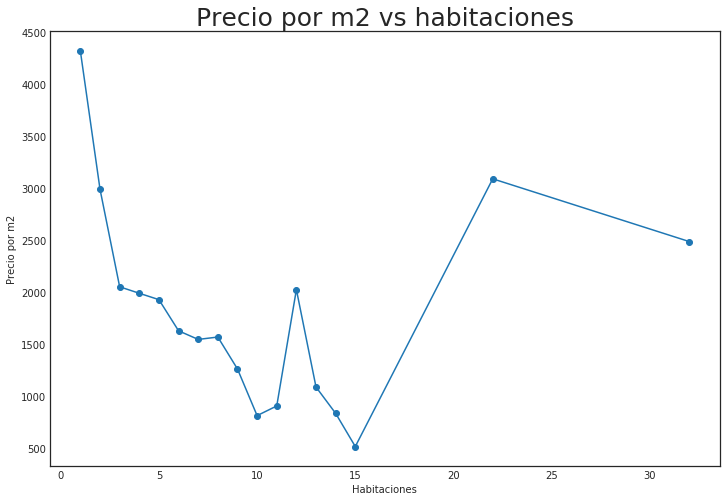

In [74]:
precio_vs_habs= properati_filtrado.loc[:,('price_usd_per_m2','rooms')].dropna()
precio_vs_habs= precio_vs_habs.groupby('rooms').mean()

titulo ='Precio por m2 vs habitaciones'
plt.figure(figsize=TAM_IMG)
plt.xlabel('Habitaciones')
plt.ylabel('Precio por m2')
plt.title(titulo,size= 25)
plt.plot(precio_vs_habs,marker="o")
guardar_imagen(titulo)
plt.show()

## Precio m2 vs años para cada tipo

/usr/lib64/python2.7/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=2017.0, right=2017.0
  'left=%s, right=%s') % (left, right))


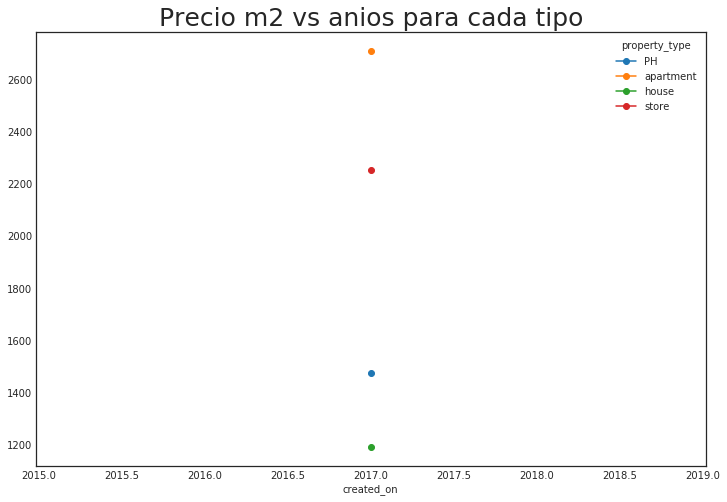

In [75]:
m2_anual = properati_filtrado.groupby([properati_filtrado.property_type,properati_filtrado.created_on.dt.year]).mean()['price_usd_per_m2'].unstack(level=0)
m2_anual.plot(kind='line',marker="o",figsize=TAM_IMG)

titulo = 'Precio m2 vs anios para cada tipo'
plt.title(titulo,size=25)
guardar_imagen(titulo)
plt.show()

##  Piso del departamento vs precio por m2

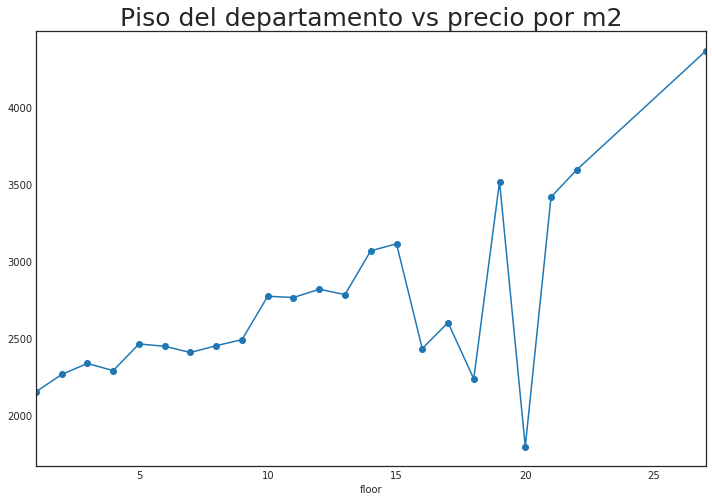

In [76]:
piso_vs_precio = properati_filtrado.loc[:,('price_usd_per_m2','floor')].dropna()
piso_vs_precio = piso_vs_precio.loc[piso_vs_precio.floor < 55] #https://es.wikipedia.org/wiki/Anexo:Edificios_m%C3%A1s_altos_de_Argentina
piso_vs_precio = piso_vs_precio.groupby(properati_filtrado.floor)
piso_vs_precio = piso_vs_precio.mean()['price_usd_per_m2']
piso_vs_precio.plot(kind='line',marker="o",figsize=TAM_IMG)

titulo ='Piso del departamento vs precio por m2'
plt.title(titulo,size=25)
guardar_imagen(titulo)
plt.show()

##  Piso del departamento vs expensas

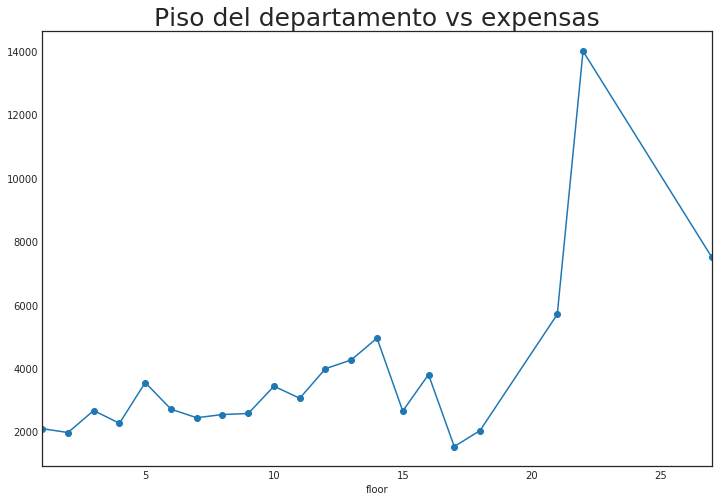

In [77]:
piso_vs_expensas = properati_filtrado.loc[:,('floor','expenses')].dropna(subset=['expenses'])
piso_vs_expensas = piso_vs_expensas.loc[properati_filtrado.floor <50]
piso_vs_expensas = piso_vs_expensas.groupby(properati_filtrado.floor).mean()['expenses']
piso_vs_expensas.plot(kind='line',marker="o",figsize=TAM_IMG)

titulo = 'Piso del departamento vs expensas'
plt.title(titulo,size=25)
guardar_imagen(titulo)
plt.show()

In [78]:
caba_para_mapa = caba.dropna(subset= ['lat','lon'])
caba_para_mapa = caba_para_mapa.loc[(caba_para_mapa.lat > -35) & (caba_para_mapa.lat < -34) & (caba_para_mapa.lon > -58.7)] #preparo para calcular distancias
caba_para_mapa['lat-lon'] = [(x, y) for x,y in zip(caba_para_mapa['lat'], caba_para_mapa['lon'])] #preparo para calcular distancias
#gp.scatter(caba_para_mapa['lat'], caba_para_mapa['lon'],colors='blue') #reviso si filtre bien "puntos malos"

In [79]:
todo_para_mapa = properati_filtrado.dropna(subset= ['lat','lon'])
todo_para_mapa['lat-lon'] = [(x, y) for x,y in zip(todo_para_mapa['lat'], todo_para_mapa['lon'])] #preparo para calcular distancias
todo_para_mapa = todo_para_mapa.loc[(todo_para_mapa.lat > -36) & (todo_para_mapa.lat < -34.2) & (todo_para_mapa.lon > -59)] 
#gp.scatter(todo_para_mapa['lat'], todo_para_mapa['lon'],colors='blue') #reviso si filtre bien "puntos malos"

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Relacion entre distancia a boca de subte vs precio por m2 CABA

In [80]:
subtes = pd.read_csv('datos/datasets/CABA/latlon/estaciones-de-subte.csv')
subtes['lat-lon'] = [(x, y) for x,y in zip(subtes['y'], subtes['x'])]

In [81]:
#gp.scatter(subtes['y'], subtes['x'],colors='red')

In [82]:
caba_para_mapa['dist_a_subte'] = [distancia_minima(x, list(subtes['lat-lon'])) for x in caba_para_mapa['lat-lon']]

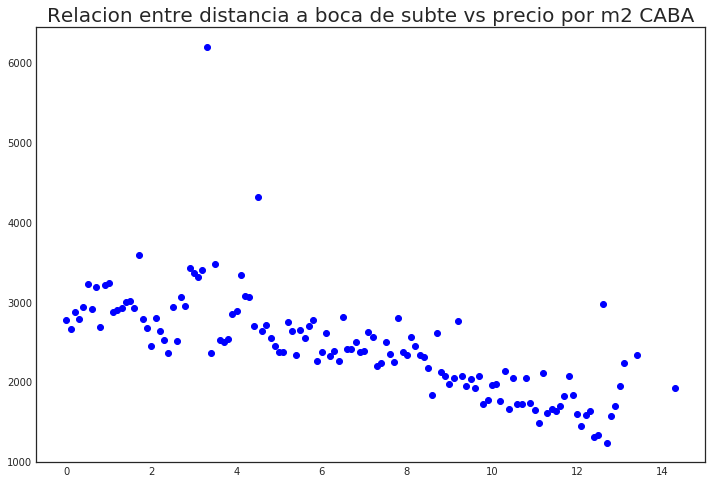

In [83]:
resultados = caba_para_mapa.loc[:,('dist_a_subte','price_usd_per_m2')].groupby('dist_a_subte').mean().reset_index()
titulo = 'Relacion entre distancia a boca de subte vs precio por m2 CABA'
plotear_distancias(resultados,'dist_a_subte','price_usd_per_m2',titulo)

In [84]:
colectivos = pd.read_csv('datos/datasets/CABA/latlon/paradas-de-colectivo.csv')

In [85]:
#gp.scatter(colectivos['Y'], colectivos['X'],colors='red')

In [86]:
metrobus = pd.read_csv('datos/datasets/CABA/latlon/estaciones-de-metrobus.csv')

In [87]:
#gp.scatter(metrobus['Y'], metrobus['X'],colors='red')

In [88]:
trenes = pd.read_csv('datos/datasets/CABA/latlon/estaciones-de-ferrocarril.csv',error_bad_lines=False)
trenes['lat-lon'] = [(x, y) for x,y in zip(trenes['LAT'], trenes['LNG'])]

In [89]:
#gp.scatter(trenes['LAT'], trenes['LNG'],colors='red')

## Relacion entre distancia a estacion de tren vs precio por m2 CABA

In [90]:
caba_para_mapa['dist_a_tren'] = [distancia_minima(x, list(trenes['lat-lon'])) for x in caba_para_mapa['lat-lon']]

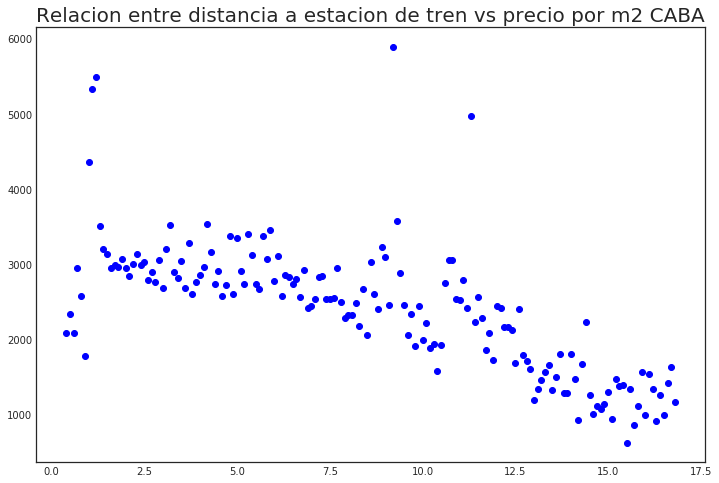

In [91]:
resultados = caba_para_mapa.loc[:,('dist_a_tren','price_usd_per_m2')].groupby('dist_a_tren').mean().reset_index()
titulo = 'Relacion entre distancia a estacion de tren vs precio por m2 CABA'
plotear_distancias(resultados,'dist_a_tren','price_usd_per_m2',titulo)

## Relacion entre distancia a una universidad vs precio por m2 CABA

In [92]:
univ = pd.read_csv('datos/datasets/CABA/latlon/universidades.csv',error_bad_lines=False)
univ['lat-lon']= [(x, y) for x,y in zip(univ['LAT'], univ['LNG'])]

KeyError: 'LAT'

In [ ]:
caba_para_mapa['dist_a_univ'] = [distancia_minima(x, list(univ['lat-lon'])) for x in caba_para_mapa['lat-lon']]

In [ ]:
resultados = caba_para_mapa.loc[:,('dist_a_univ','price_usd_per_m2')].groupby('dist_a_univ').mean().reset_index()
titulo = 'Relacion entre distancia a una universidad vs precio por m2 CABA'
plotear_distancias(resultados,'dist_a_univ','price_usd_per_m2',titulo)

## Relacion entre distancia a una villas (o asentamiento) vs precio por m2 CABA

In [ ]:
villas = pd.read_csv('datos/datasets/no_CABA/poligonos/informacin-socioeconmica-asentamientos-y-villas-ong-techo.csv')
villas= villas.loc[villas['provincia']=='CABA']
villas['geojson']= [shape(geojson.loads(x)).centroid.xy for x in villas['geojson'].values]
villas['geojson']  = [(y[0],x[0]) for x,y in villas['geojson']]

In [ ]:
caba_para_mapa.loc[:,('dist_a_villa')] = [distancia_minima(x,list(villas.loc[:,('geojson')])) for x in caba_para_mapa.loc[:,('lat-lon')]] 

In [ ]:
resultados = caba_para_mapa.loc[:,('dist_a_villa','price_usd_per_m2')].groupby('dist_a_villa').mean().reset_index()
titulo = 'Relacion entre distancia a una villas (o asentamiento) vs precio por m2 CABA'
plotear_distancias(resultados,'dist_a_villa','price_usd_per_m2',titulo)

In [ ]:
#with open("datos/datasets/CABA/poligonos/sitios-pasibles-de-anegamiento-por-precipitacion-2014.geojson") as json_file:
    #geo_data=geojson.load(json_file)

In [ ]:
#lat=[]
#lon=[]
#cluster=[]
#count=0
#for element in geo_data['features']:
   # for coordinate in element['geometry']['coordinates'][0][0]:
        #lat.append(coordinate[0])
        #lon.append(coordinate[1])
        #cluster.append(count)
    #count+=1

In [ ]:
#zonas_anegadas=pd.DataFrame({'lat':lat,'lon':lon,'cluster':cluster})
#zonas_anegadas['lat-lon']=[(x, y) for x,y in zip(zonas_anegadas['lat'], zonas_anegadas['lon'])]
   

In [ ]:
#gp.polygons(zonas_anegadas['lon'],zonas_anegadas['lat'],zonas_anegadas['cluster'])


In [ ]:
caba_para_mapa['dist_a_zona_anegada'] = [distancia_minima(x, list(zonas_anegadas['lat-lon'])) for x in caba_para_mapa['lat-lon']]


In [ ]:
resultados = caba_para_mapa.loc[:,('dist_a_zona_anegada','price_usd_per_m2')].groupby('dist_a_zona_anegada').mean().reset_index()
plotear_distancias(resultados,'dist_a_zona_anegada','price_usd_per_m2')

# <span style="color:red"> Poner nombre a ejes de graficos y refactorizar. Insertar columnas adicionales como a estrenar, con jardin, con gimnasio en dataframe principal